# Melanoma Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) for melanoma detection using processed images.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Set random seeds for reproducibility
from pathlib import Path
import albumentations as A
import random
from sklearn.utils import shuffle
from tensorflow.keras.applications import ResNet50V2
import json
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices()}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Load and Prepare Data

We'll load the processed images for melanoma classification.

In [3]:
# Set paths
base_path = Path('../../../')
processed_dir = base_path / "working" / "processed"
augmented_dir = base_path / "working" / "augmented"
melanoma_dir = processed_dir / "melanoma"
non_melanoma_dir = processed_dir / "non_melanoma"

melanoma_augmented_dir = augmented_dir / "melanoma"
non_melanoma_augmented_dir = augmented_dir / "non_melanoma"

In [19]:
# Function to load images from directories
def load_images_from_directory(directory, label):
    images = []
    labels = []

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return images, labels

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'): # Assuming images are JPG, adjust if other formats are present
            img_path = os.path.join(directory, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Could not read image {img_path}. It might be corrupted or not a valid image file.")
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return images, labels


# Load melanoma and non-melanoma images
print("Loading melanoma images...")
melanoma_images, melanoma_labels = load_images_from_directory(melanoma_dir, 1)

print("Loading augmented melanoma images...")
augmented_melanoma_images, augmented_melanoma_labels = load_images_from_directory(
    melanoma_augmented_dir, 1)

# Load non-melanoma images
print("Loading non-melanoma augmented images...")
non_melanoma_augmented_images, non_melanoma_augmented_labels = load_images_from_directory(
    non_melanoma_augmented_dir, 0)

print("Loading non-melanoma images...")
non_melanoma_images, non_melanoma_labels = load_images_from_directory(
    non_melanoma_dir, 0)


Loading melanoma images...
Loading augmented melanoma images...
Loading non-melanoma augmented images...
Loading non-melanoma images...


In [10]:
print(f"Loaded {len(melanoma_images)} melanoma images.")
print(f"Loaded {len(augmented_melanoma_images)} augmented melanoma images.")
print(f"Loaded {len(non_melanoma_images)} non-melanoma images.")
print(f"Loaded {len(non_melanoma_augmented_images)} augmented non-melanoma images.")
print(f"\nTotal Melanoma images: {len(melanoma_images) + len(augmented_melanoma_images)}")
print(f"Total Non-Melanoma images: {len(non_melanoma_images) + len(non_melanoma_augmented_images)}")

Loaded 4522 melanoma images.
Loaded 2226 augmented melanoma images.
Loaded 20809 non-melanoma images.
Loaded 10411 augmented non-melanoma images.

Total Melanoma images: 6748
Total Non-Melanoma images: 31220


In [29]:
# Combine datasets
X = np.array(melanoma_images + non_melanoma_images[:4522] + augmented_melanoma_images + non_melanoma_augmented_images[:2226])
y = np.array(melanoma_labels + non_melanoma_labels[:4522] + augmented_melanoma_labels + non_melanoma_augmented_labels[:2226])

# Print dataset information
print(f"Dataset loaded: {X.shape} images")

Dataset loaded: (13496, 224, 224, 3) images


In [ ]:
# Balancing the data set with the same number of melanoma samples since we'll augment them
target_samples = 8000

print(f"Original dataset - Melanoma: {len(melanoma_images)}, Non-melanoma: {len(non_melanoma_images)}")

# 1. Subsample non-melanoma images to reduce class imbalance
non_melanoma_indices = list(range(len(non_melanoma_images)))
random.seed(42)
random.shuffle(non_melanoma_indices)
non_melanoma_indices = non_melanoma_indices[:target_samples]
non_melanoma_images_balanced = [non_melanoma_images[i] for i in non_melanoma_indices]
non_melanoma_labels_balanced = [non_melanoma_labels[i] for i in non_melanoma_indices]

print(f"After subsampling - Non-melanoma: {len(non_melanoma_images_balanced)}")

# 2. Create augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.GridDistortion(p=0.3),
    A.ElasticTransform(p=0.3),
])

melanoma_images_augmented = melanoma_images.copy()
melanoma_labels_augmented = melanoma_labels.copy()

print("Augmenting melanoma images...")

# Generate augmented images for the melanoma class to balance dataset
num_augmentations_needed = target_samples - len(melanoma_images)
images_to_augment = random.choices(melanoma_images, k=num_augmentations_needed)

for img in images_to_augment:
    img_uint8 = img.astype(np.uint8)
    augmented = augmentation(image=img_uint8)
    melanoma_images_augmented.append(augmented['image'])
    melanoma_labels_augmented.append(1)

print(f"After augmentation - Melanoma: {len(melanoma_images_augmented)}")

# Create balanced dataset
X_balanced = np.array(melanoma_images_augmented + non_melanoma_images_balanced)
y_balanced = np.array(melanoma_labels_augmented + non_melanoma_labels_balanced)

# Shuffle the data
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# Reshape and normalize images for CNN input
X_balanced = X_balanced.reshape(-1, 224, 224, 1).astype('float32') / 255.0

print(f"Balanced dataset - Total: {X_balanced.shape[0]} images")
print(f"Class distribution - Melanoma: {np.sum(y_balanced == 1)}, Non-melanoma: {np.sum(y_balanced == 0)}")

# Replace original X and y with balanced dataset
X, y = X_balanced, y_balanced


In [33]:
# Split data into training, validation, and test sets
# First split: 80% training+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 80% training, 20% validation (from the training+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape} images")
print(f"Validation set: {X_val.shape} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution in each set
print(f"Training set - Melanoma: {np.sum(y_train == 1)}, Non-melanoma: {np.sum(y_train == 0)}")
print(f"Validation set - Melanoma: {np.sum(y_val == 1)}, Non-melanoma: {np.sum(y_val == 0)}")
print(f"Test set - Melanoma: {np.sum(y_test == 1)}, Non-melanoma: {np.sum(y_test == 0)}")

Training set: (8636, 224, 224, 3) images
Validation set: (2160, 224, 224, 3) images
Test set: 2700 images
Training set - Melanoma: 4262, Non-melanoma: 4374
Validation set - Melanoma: 1095, Non-melanoma: 1065
Test set - Melanoma: 1391, Non-melanoma: 1309


## 2. Build CNN Model

We'll create a CNN model architecture suitable for melanoma classification.

In [36]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
NUM_CLASSES = 1


def build_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)):
    base_model = ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=None,  # We'll add our own pooling layer
    )
    base_model.trainable = False  # Freeze the base model
    # Compile model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    outputs = tf.keras.layers.Dense(
        NUM_CLASSES, activation="sigmoid", name="classifier"
    )(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Melanoma_ResNet50V2")
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),  # Recall is Sensitivity
        ],
    )
    return model


# Build the model
model = build_cnn_model()
model.summary()

Model: "Melanoma_ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [37]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('../working/melanoma_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Calculate class weights to handle imbalance
class_weight = {
    0: 1.0,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if np.sum(y_train == 1) > 0 else 1.0
}
print(f"Class weights: {class_weight}")

Class weights: {0: 1.0, 1: 1.0262787423744721}


In [38]:
X_train.shape

(8636, 224, 224, 3)

In [39]:
# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1,
)

Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5880 - auc: 0.5940 - loss: 26.1066 - precision: 0.5750 - recall: 0.4025
Epoch 1: val_auc improved from -inf to 0.70839, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 179s 645ms/step - accuracy: 0.5882 - auc: 0.5942 - loss: 26.0544 - precision: 0.5753 - recall: 0.4032 - val_accuracy: 0.6787 - val_auc: 0.7084 - val_loss: 4.0483 - val_precision: 0.7135 - val_recall: 0.6119 - learning_rate: 1.0000e-04
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.6991 - auc: 0.7275 - loss: 3.2531 - precision: 0.6981 - recall: 0.6898
Epoch 2: val_auc improved from 0.70839 to 0.75127, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 264s 978ms/step - accuracy: 0.6991 - auc: 0.7275 - loss: 3.2516 - precision: 0.6981 - recall: 0.6898 - val_accuracy: 0.6981 - val_auc: 0.7513 - val_loss: 2.3352 - val_precision: 0.7549 - val_recall: 0.5991 - learning_rate: 1.0000e-04
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7149 - auc: 0.7644 - loss: 1.9870 - precision: 0.7132 - recall: 0.7092
Epoch 3: val_auc improved from 0.75127 to 0.77928, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 243s 899ms/step - accuracy: 0.7149 - auc: 0.7644 - loss: 1.9865 - precision: 0.7131 - recall: 0.7092 - val_accuracy: 0.7060 - val_auc: 0.7793 - val_loss: 1.6919 - val_precision: 0.7738 - val_recall: 0.5936 - learning_rate: 1.0000e-04
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.7176 - auc: 0.7772 - loss: 1.5200 - precision: 0.7156 - recall: 0.7118
Epoch 4: val_auc improved from 0.77928 to 0.78484, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7176 - auc: 0.7772 - loss: 1.5198 - precision: 0.7156 - recall: 0.7118 - val_accuracy: 0.7125 - val_auc: 0.7848 - val_loss: 1.4950 - val_precision: 0.8023 - val_recall: 0.5744 - learning_rate: 1.0000e-04
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7164 - auc: 0.7852 - loss: 1.3352 - precision: 0.7132 - recall: 0.7123
Epoch 5: val_auc improved from 0.78484 to 0.79239, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.7164 - auc: 0.7852 - loss: 1.3351 - precision: 0.7132 - recall: 0.7123 - val_accuracy: 0.7190 - val_auc: 0.7924 - val_loss: 1.3301 - val_precision: 0.8035 - val_recall: 0.5900 - learning_rate: 1.0000e-04
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7187 - auc: 0.7941 - loss: 1.2150 - precision: 0.7155 - recall: 0.7144
Epoch 6: val_auc improved from 0.79239 to 0.79967, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7187 - auc: 0.7941 - loss: 1.2149 - precision: 0.7155 - recall: 0.7144 - val_accuracy: 0.7273 - val_auc: 0.7997 - val_loss: 1.2323 - val_precision: 0.8100 - val_recall: 0.6037 - learning_rate: 1.0000e-04
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7253 - auc: 0.8006 - loss: 1.1257 - precision: 0.7234 - recall: 0.7183
Epoch 7: val_auc improved from 0.79967 to 0.80466, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.7253 - auc: 0.8006 - loss: 1.1257 - precision: 0.7234 - recall: 0.7183 - val_accuracy: 0.7329 - val_auc: 0.8047 - val_loss: 1.1746 - val_precision: 0.8229 - val_recall: 0.6027 - learning_rate: 1.0000e-04
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7333 - auc: 0.8075 - loss: 1.0574 - precision: 0.7313 - recall: 0.7266
Epoch 8: val_auc improved from 0.80466 to 0.81074, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.7333 - auc: 0.8074 - loss: 1.0574 - precision: 0.7313 - recall: 0.7265 - val_accuracy: 0.7403 - val_auc: 0.8107 - val_loss: 1.1234 - val_precision: 0.8346 - val_recall: 0.6082 - learning_rate: 1.0000e-04
Epoch 9/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7381 - auc: 0.8131 - loss: 1.0033 - precision: 0.7360 - recall: 0.7325
Epoch 9: val_auc improved from 0.81074 to 0.81444, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.7381 - auc: 0.8131 - loss: 1.0033 - precision: 0.7359 - recall: 0.7325 - val_accuracy: 0.7449 - val_auc: 0.8144 - val_loss: 1.0611 - val_precision: 0.8342 - val_recall: 0.6201 - learning_rate: 1.0000e-04
Epoch 10/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.7390 - auc: 0.8180 - loss: 0.9578 - precision: 0.7360 - recall: 0.7354
Epoch 10: val_auc improved from 0.81444 to 0.81743, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7390 - auc: 0.8179 - loss: 0.9579 - precision: 0.7360 - recall: 0.7353 - val_accuracy: 0.7486 - val_auc: 0.8174 - val_loss: 1.0031 - val_precision: 0.8309 - val_recall: 0.6329 - learning_rate: 1.0000e-04
Epoch 11/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7407 - auc: 0.8214 - loss: 0.9193 - precision: 0.7388 - recall: 0.7347
Epoch 11: val_auc improved from 0.81743 to 0.81954, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7407 - auc: 0.8214 - loss: 0.9193 - precision: 0.7388 - recall: 0.7347 - val_accuracy: 0.7532 - val_auc: 0.8195 - val_loss: 0.9575 - val_precision: 0.8314 - val_recall: 0.6438 - learning_rate: 1.0000e-04
Epoch 12/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.7409 - auc: 0.8251 - loss: 0.8866 - precision: 0.7393 - recall: 0.7343
Epoch 12: val_auc improved from 0.81954 to 0.82273, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.7409 - auc: 0.8250 - loss: 0.8866 - precision: 0.7393 - recall: 0.7343 - val_accuracy: 0.7537 - val_auc: 0.8227 - val_loss: 0.9225 - val_precision: 0.8285 - val_recall: 0.6484 - learning_rate: 1.0000e-04
Epoch 13/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.7430 - auc: 0.8284 - loss: 0.8588 - precision: 0.7404 - recall: 0.7387
Epoch 13: val_auc improved from 0.82273 to 0.82549, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.7430 - auc: 0.8284 - loss: 0.8589 - precision: 0.7404 - recall: 0.7387 - val_accuracy: 0.7551 - val_auc: 0.8255 - val_loss: 0.8940 - val_precision: 0.8283 - val_recall: 0.6521 - learning_rate: 1.0000e-04
Epoch 14/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7451 - auc: 0.8311 - loss: 0.8351 - precision: 0.7443 - recall: 0.7374
Epoch 14: val_auc improved from 0.82549 to 0.82755, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.7451 - auc: 0.8310 - loss: 0.8351 - precision: 0.7442 - recall: 0.7374 - val_accuracy: 0.7574 - val_auc: 0.8276 - val_loss: 0.8697 - val_precision: 0.8278 - val_recall: 0.6584 - learning_rate: 1.0000e-04
Epoch 15/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.7493 - auc: 0.8327 - loss: 0.8144 - precision: 0.7488 - recall: 0.7411
Epoch 15: val_auc improved from 0.82755 to 0.82942, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7493 - auc: 0.8327 - loss: 0.8145 - precision: 0.7488 - recall: 0.7411 - val_accuracy: 0.7560 - val_auc: 0.8294 - val_loss: 0.8488 - val_precision: 0.8220 - val_recall: 0.6621 - learning_rate: 1.0000e-04
Epoch 16/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7520 - auc: 0.8346 - loss: 0.7960 - precision: 0.7520 - recall: 0.7429
Epoch 16: val_auc improved from 0.82942 to 0.83112, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.7520 - auc: 0.8346 - loss: 0.7961 - precision: 0.7520 - recall: 0.7429 - val_accuracy: 0.7616 - val_auc: 0.8311 - val_loss: 0.8315 - val_precision: 0.8258 - val_recall: 0.6712 - learning_rate: 1.0000e-04
Epoch 17/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.7538 - auc: 0.8361 - loss: 0.7797 - precision: 0.7543 - recall: 0.7439
Epoch 17: val_auc improved from 0.83112 to 0.83289, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7538 - auc: 0.8361 - loss: 0.7797 - precision: 0.7543 - recall: 0.7439 - val_accuracy: 0.7602 - val_auc: 0.8329 - val_loss: 0.8173 - val_precision: 0.8245 - val_recall: 0.6694 - learning_rate: 1.0000e-04
Epoch 18/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.7543 - auc: 0.8379 - loss: 0.7650 - precision: 0.7545 - recall: 0.7449
Epoch 18: val_auc improved from 0.83289 to 0.83432, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7543 - auc: 0.8378 - loss: 0.7651 - precision: 0.7545 - recall: 0.7449 - val_accuracy: 0.7611 - val_auc: 0.8343 - val_loss: 0.8057 - val_precision: 0.8249 - val_recall: 0.6712 - learning_rate: 1.0000e-04
Epoch 19/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7547 - auc: 0.8394 - loss: 0.7519 - precision: 0.7552 - recall: 0.7447
Epoch 19: val_auc improved from 0.83432 to 0.83533, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7547 - auc: 0.8394 - loss: 0.7520 - precision: 0.7552 - recall: 0.7447 - val_accuracy: 0.7602 - val_auc: 0.8353 - val_loss: 0.7962 - val_precision: 0.8260 - val_recall: 0.6676 - learning_rate: 1.0000e-04
Epoch 20/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.7550 - auc: 0.8413 - loss: 0.7401 - precision: 0.7564 - recall: 0.7434
Epoch 20: val_auc improved from 0.83533 to 0.83647, saving model to ../working/melanoma_model.h5


270/270 ━━━━━━━━━━━━━━━━━━━━ 223s 826ms/step - accuracy: 0.7550 - auc: 0.8413 - loss: 0.7402 - precision: 0.7564 - recall: 0.7434 - val_accuracy: 0.7616 - val_auc: 0.8365 - val_loss: 0.7883 - val_precision: 0.8288 - val_recall: 0.6676 - learning_rate: 1.0000e-04


## 3. Evaluate Model Performance

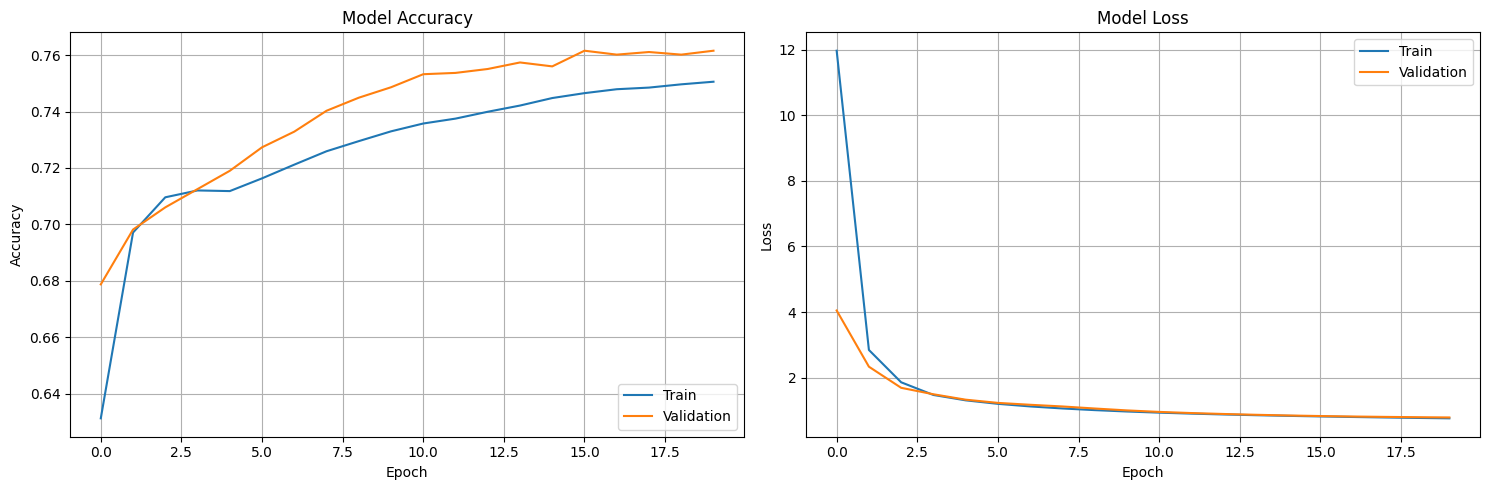

In [40]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [42]:
# Evaluate on test set
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall (Sensitivity): {test_recall:.4f}")

# Make predictions on test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Melanoma', 'Melanoma']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Test Loss: 0.7276
Test Accuracy: 0.7663
Test AUC: 0.8520
Test Precision: 0.8387
Test Recall (Sensitivity): 0.6765
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 703ms/step

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.71      0.86      0.78      1309
    Melanoma       0.84      0.68      0.75      1391

    accuracy                           0.77      2700
   macro avg       0.78      0.77      0.77      2700
weighted avg       0.78      0.77      0.76      2700


Confusion Matrix:
[[1128  181]
 [ 450  941]]


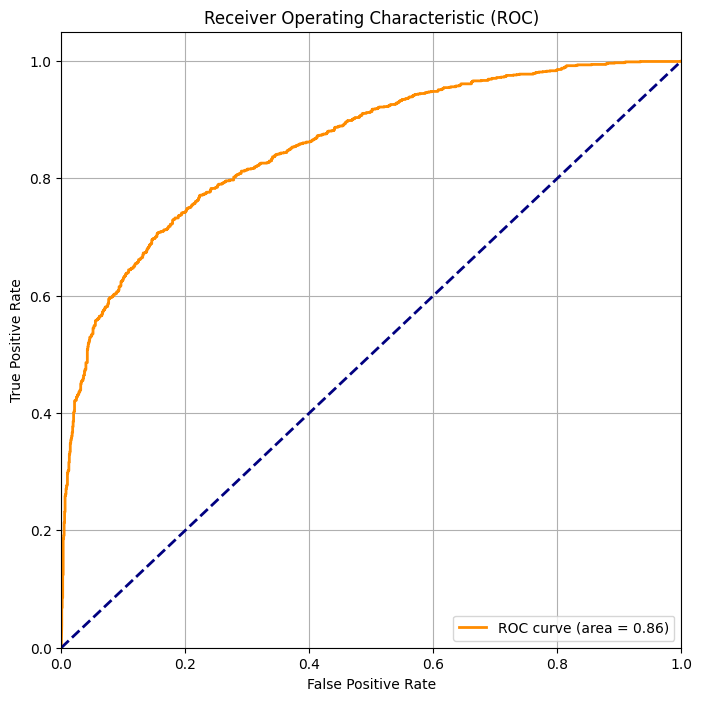

In [43]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

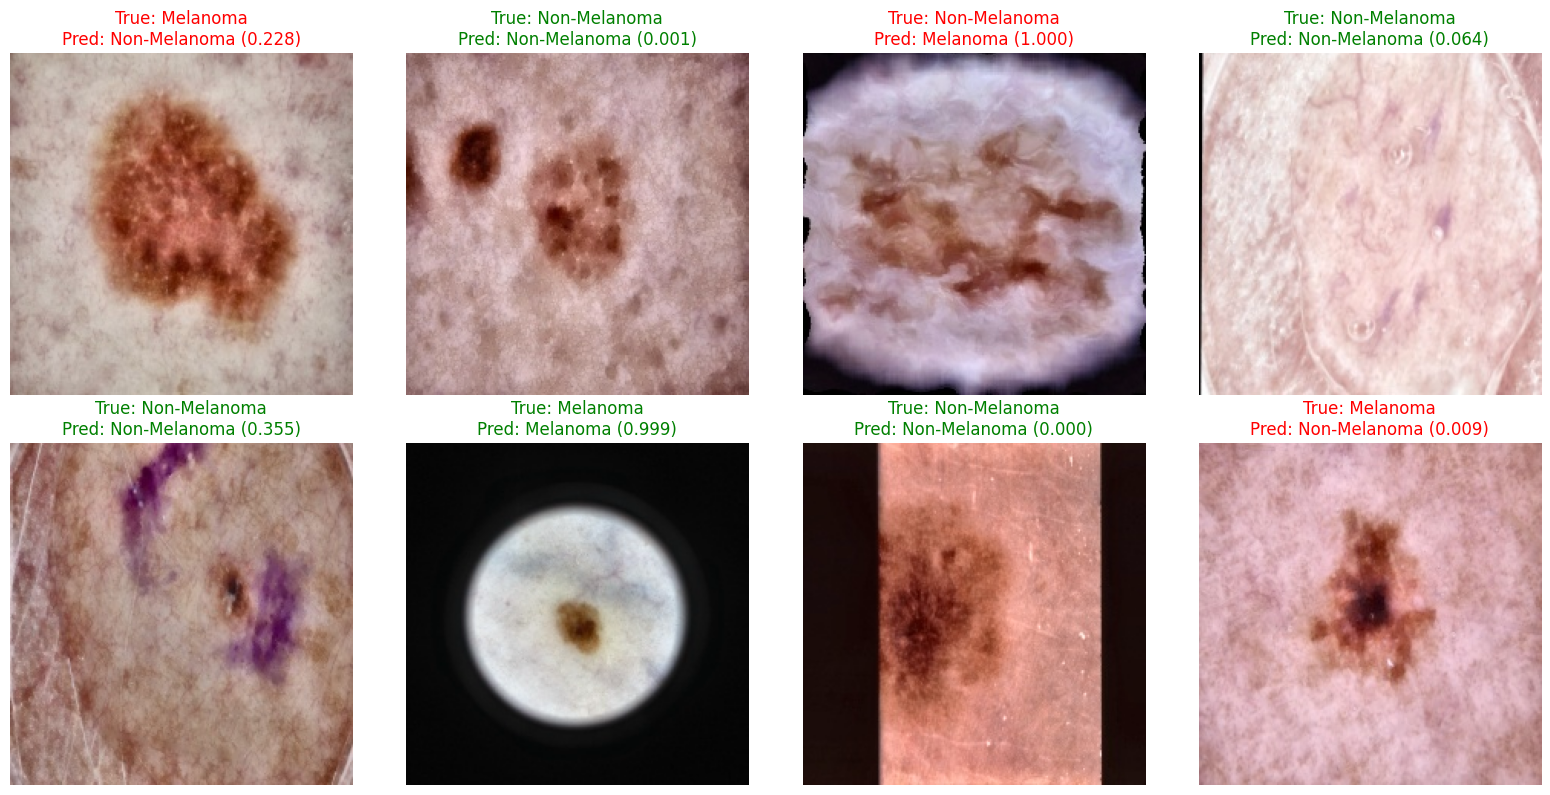

In [45]:
# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, y_pred_proba, num_samples=8):
    # Select random samples
    indices = np.random.choice(
        range(len(y_true)), min(num_samples, len(y_true)), replace=False
    )

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        # Get image and labels
        img = X[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_pred_proba[idx][0]

        # Determine text color based on prediction correctness
        color = "green" if true_label == pred_label else "red"

        # Plot image
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(
            f"True: {'Melanoma' if true_label == 1 else 'Non-Melanoma'}\n"
            + f"Pred: {'Melanoma' if pred_label == 1 else 'Non-Melanoma'} ({prob:.3f})",
            color=color,
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize predictions
visualize_predictions(X_test, y_test, y_pred, y_pred_proba)

## 4. Save Model and Results

In [ ]:
# Save model
model_path = "../working/melanoma_revisited_final_1.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

# Save test results
results = {
    "accuracy": float(test_acc),
    "auc": float(test_auc),
    "loss": float(test_loss),
}

with open("../working/model_results.json", "w") as f:
    json.dump(results, f)
print("Results saved to ../working/model_results.json")

Model saved to ../working/melanoma_revisited_final_1.h5
Results saved to ../working/model_results.json
